# S2CA2 BDSP_ADA : Tweet Sentiment Analysis processed using Big Data Processing & Time-Series Forecasting for sentiment score.

## Methodology

Below is the methodology and steps performed for the purpose of assignment

STEP 1 : Load the Dataset in csv format file to Pyspark (installed on Windows local computer) to benefit from performances of big data tech to handle pre-processing operations on Dataset. Pre-processing of data to clean, perform missing value analysis, duplicate analysis before performing sentiment analysis. 

Step 2 : Sentiment Analysis using VADER, TEXTBLOB, NLTK Classifier with result of  Sentiment Score & Label Generation.

Step 3 : Storing of dataset with sentiment score & Label to MongoDB and MySQL for DB performance task , retrieval for Data Visualization & Forecasting.

Step 4 : Interactive Dashboard of Sentiment Analysis of dataset to understand the data using Dash/Plotly. 

Step 5 : Different Interpolation techniques to generate missing dates in the data set before Forecasting applied & compared for performance. 

Step 6: Time-Series forecasting to predict 1 week, 1 Month and 3 Month sentiment score using ARIMA / SARIMAX / VARMAX / Exponetial Smoothing and Compartive results based on outcome. 

Step 7: Conclusions included in the report.


## STEP1 : Loading the Dataset in CSV file to Pyspark and Pre-processing of Dataset 

### 1.1 Library Import as required

In [189]:
#Import of Libraries required for the program
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from pymongo import MongoClient
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from wordcloud import WordCloud
from pyspark.ml.feature import Tokenizer, IDF, StringIndexer, VectorAssembler
# from pyspark.ml.feature import IDF
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.express as px
from textblob import TextBlob
import numpy as np
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.tokenize import word_tokenize
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.model_selection import TimeSeriesSplit
# Ignore the ConvergenceWarnings specifically
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import EstimationWarning
# Suppress EstimationWarning
warnings.simplefilter('ignore', EstimationWarning)
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from jupyter_dash import JupyterDash
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [61]:
# Ignore all warnings
warnings.filterwarnings('ignore')


### 1.2 Loading of Dataset to Pyspark

In [68]:
# configure system requirement to run pyspark for driver and executor
conf = SparkConf().set("spark.driver.memory", "8g") \
                   .set("spark.executor.memory", "8g")

In [69]:
# create a pyspark session
spark = SparkSession.builder \
    .appName("CA2S2 BDSP ADA") \
    .getOrCreate()


In [70]:
# Load the CSV file into a DataFrame
file_path = "ProjectTweets.csv"
df = spark.read.csv(file_path, header=False, inferSchema=True)

In [71]:
df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [72]:
# Drop the first column (index column)
df = df.drop("_c0", "_c3",)

In [73]:
# Add column names
df = df.withColumnRenamed("_c1", "ids") \
    .withColumnRenamed("_c2", "date") \
    .withColumnRenamed("_c4", "username") \
    .withColumnRenamed("_c5", "text")


In [74]:
#describe dataset to understand data
df.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+
|summary|                 ids|                date|            username|                text|
+-------+--------------------+--------------------+--------------------+--------------------+
|  count|             1600000|             1600000|             1600000|             1600000|
|   mean|1.9988175522956276E9|                null| 4.325887521835714E9|                null|
| stddev|1.9357607362267742E8|                null|5.162733218454887...|                null|
|    min|          1467810369|Fri Apr 17 20:30:...|        000catnap000|                 ...|
|    max|          2329205794|Wed May 27 07:27:...|          zzzzeus111|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|
+-------+--------------------+--------------------+--------------------+--------------------+



### 1.3 Pre-processing of Data

In [75]:
# drop missing data observations using pyspark library
df.dropna()

DataFrame[ids: bigint, date: string, username: string, text: string]

In [76]:
#drop duplicate observations bsaed on tweet Id using pyspark libary
df.dropDuplicates(subset=["ids"])

DataFrame[ids: bigint, date: string, username: string, text: string]

In [77]:
# describe the dataset using pyspark library
df.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+
|summary|                 ids|                date|            username|                text|
+-------+--------------------+--------------------+--------------------+--------------------+
|  count|             1600000|             1600000|             1600000|             1600000|
|   mean|1.9988175522956276E9|                null| 4.325887521835714E9|                null|
| stddev|1.9357607362267742E8|                null|5.162733218454887...|                null|
|    min|          1467810369|Fri Apr 17 20:30:...|        000catnap000|                 ...|
|    max|          2329205794|Wed May 27 07:27:...|          zzzzeus111|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|
+-------+--------------------+--------------------+--------------------+--------------------+



##  Step 2 : Sentiment Analysis of tweets

###  NOTE: Code to perform Vader sentiment Analysis using Pyspark Libraries 

In [22]:

# from pyspark.sql.functions import col, udf
# from pyspark.sql.types import FloatType
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

# # Define a UDF for VADER sentiment analysis
# def analyze_sentiment_vader(text):
#     sentiment = analyzer.polarity_scores(text)
#     return sentiment['compound']

# # Register the UDF
# analyze_sentiment_vader_udf = udf(analyze_sentiment_vader, FloatType())

# # Apply VADER sentiment analysis and create a new column 'vader_sentiment'
# df_vader = df.withColumn('vader_sentiment', analyze_sentiment_vader_udf(df['text']))


# Py4JJavaError: An error occurred while calling o86.showString.
# : org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 12.0 failed 1 times, most recent failure:
#                 Lost task 0.0 in stage 12.0 (TID 85) (sureshk2-z01 executor driver): org.apache.spark.SparkException: 
#                         Python worker failed to connect back

 NOte: Pyspark code executes for Vader sentiment analysis but crashes after vader sentiment analysis is run. Error captured in above cell which could not be solved because of limited resources on personal computer & Java interactions. Converted dataframe to Pandas to perform Vader sentiment Analysis

In [78]:
#pyspark dataframe conversted to Pandas Dataframe
pandas_df = df.toPandas()


In [79]:
pandas_df.head(5)

,ids,date,username,text
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [80]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   ids       1600000 non-null  int64 
 1   date      1600000 non-null  object
 2   username  1600000 non-null  object
 3   text      1600000 non-null  object
dtypes: int64(1), object(3)
memory usage: 48.8+ MB


In [81]:
pandas_df["date"] = pd.to_datetime(pandas_df["date"])

In [82]:
pandas_df.head(5)

,ids,date,username,text
0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


### 2.1 Peform VADER Sentiment Analysis

In [83]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [84]:
# Create a function to clean the text
def clean_text(text):
    """
    Clean the text by removing mentions, hashtags, retweets, hyperlinks, and colons.
    
    Parameters:
    text (str): The text to be cleaned.
    
    Returns:
    str: The cleaned text.
    """
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions by replacing them with blank
    text = re.sub(r'#', '', text)  # Remove the '#' symbol by replacing it with blank
    text = re.sub(r'RT[\s]+', '', text)  # Remove retweets by replacing them with blank
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove hyperlinks
    text = re.sub(r':', '', text)  # Remove colons
    text = text.lower()  # Convert to lowercase
    
    return text

# Function to remove emoji and Unicode from the comment data
def remove_emoji(string):
    """
    Remove emoji and Unicode characters from a string.
    
    Parameters:
    string (str): The string to remove emoji and Unicode from.
    
    Returns:
    str: The string without emoji and Unicode characters.
    """
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # Chinese characters
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


In [85]:
# Define a function for VADER sentiment analysis
def analyze_sentiment_vader(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

In [86]:
# Clean the text in the 'comment' column of reddit_df
pandas_df['text'] = pandas_df['text'].apply(clean_text)

In [87]:
 # Clean the text in the 'comment' column by removing emoji and Unicode characters
pandas_df['text'] = pandas_df['text'].apply(remove_emoji)

In [88]:
# Apply VADER sentiment analysis
pandas_df['vader_sentiment'] = pandas_df['text'].apply(analyze_sentiment_vader)

In [89]:
pandas_df.head(50)

,ids,date,username,text,vader_sentiment
0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",-0.2023
1,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his facebook by ...,-0.7500
2,1467810917,2009-04-06 22:19:53,mattycus,i dived many times for the ball. managed to s...,0.4939
3,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,-0.2500
4,1467811193,2009-04-06 22:19:57,Karoli,"no, it's not behaving at all. i'm mad. why am...",-0.6597
5,1467811372,2009-04-06 22:20:00,joy_wolf,not the whole crew,0.0000
6,1467811592,2009-04-06 22:20:03,mybirch,need a hug,0.4767
7,1467811594,2009-04-06 22:20:03,coZZ,"hey long time no see! yes.. rains a bit ,onl...",0.6800
8,1467811795,2009-04-06 22:20:05,2Hood4Hollywood,_k nope they didn't have it,0.0000
9,1467812025,2009-04-06 22:20:09,mimismo,que me muera ?,0.0000


### 2.2 Perform TextBlob Sentiment Analysis

In [90]:
# Define a function for TextBlob sentiment analysis
def analyze_sentiment_textblob(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [91]:
# Apply TextBlob sentiment analysis
pandas_df['textblob_sentiment'] = pandas_df['text'].apply(analyze_sentiment_textblob)

In [92]:
pandas_df['sentiment_label'] = 'Neutral'  # Default value

In [93]:
# Apply conditions and update the 'sentiment_label' column
pandas_df.loc[pandas_df['vader_sentiment'] > 0.05, 'sentiment_label'] = 'Positive'
pandas_df.loc[pandas_df['vader_sentiment'] < -0.05, 'sentiment_label'] = 'Negative'

In [94]:
pandas_df.head(10)

,ids,date,username,text,vader_sentiment,textblob_sentiment,sentiment_label
0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",-0.2023,0.200000,Negative
1,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his facebook by ...,-0.7500,0.000000,Negative
2,1467810917,2009-04-06 22:19:53,mattycus,i dived many times for the ball. managed to s...,0.4939,0.500000,Positive
3,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,-0.2500,0.200000,Negative
4,1467811193,2009-04-06 22:19:57,Karoli,"no, it's not behaving at all. i'm mad. why am...",-0.6597,-0.625000,Negative
5,1467811372,2009-04-06 22:20:00,joy_wolf,not the whole crew,0.0000,0.200000,Neutral
6,1467811592,2009-04-06 22:20:03,mybirch,need a hug,0.4767,0.000000,Positive
7,1467811594,2009-04-06 22:20:03,coZZ,"hey long time no see! yes.. rains a bit ,onl...",0.6800,0.270833,Positive
8,1467811795,2009-04-06 22:20:05,2Hood4Hollywood,_k nope they didn't have it,0.0000,0.000000,Neutral
9,1467812025,2009-04-06 22:20:09,mimismo,que me muera ?,0.0000,0.000000,Neutral


### 2.3 Perform NLTK Sentiment Analysis using Naive Bayes Classifier

In [95]:
# Define a function for NLTK sentiment analysis using a Naive Bayes classifier
def train_nltk_classifier():
    # Load the subjectivity dataset
    subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')]
    obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')]
    train_subj_docs = subj_docs[:80]
    test_subj_docs = subj_docs[80:100]
    train_obj_docs = obj_docs[:80]
    test_obj_docs = obj_docs[80:100]
    training_docs = train_subj_docs + train_obj_docs
    testing_docs = test_subj_docs + test_obj_docs
    sentim_analyzer = SentimentAnalyzer()
    all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])
    unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
    sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)
    training_set = sentim_analyzer.apply_features(training_docs)
    test_set = sentim_analyzer.apply_features(testing_docs)
    trainer = NaiveBayesClassifier.train
    classifier = sentim_analyzer.train(trainer, training_set)
    return classifier

In [96]:
SentiClassifier = train_nltk_classifier()

Training classifier


In [97]:
def analyze_sentiment_nltk(text):
    unigrams = extract_unigram_feats(text.split())
    sentiment = SentiClassifier.classify(unigrams)
    return sentiment

In [98]:
def extract_unigram_feats(document_words):
    return dict([(word, True) for word in document_words])

In [99]:
# Apply NLTK sentiment analysis
pandas_df['nltk_sentiment'] = pandas_df['text'].apply(analyze_sentiment_nltk)

In [100]:
pandas_df.head(10)

,ids,date,username,text,vader_sentiment,textblob_sentiment,sentiment_label,nltk_sentiment
0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",-0.2023,0.200000,Negative,subj
1,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his facebook by ...,-0.7500,0.000000,Negative,subj
2,1467810917,2009-04-06 22:19:53,mattycus,i dived many times for the ball. managed to s...,0.4939,0.500000,Positive,subj
3,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,-0.2500,0.200000,Negative,subj
4,1467811193,2009-04-06 22:19:57,Karoli,"no, it's not behaving at all. i'm mad. why am...",-0.6597,-0.625000,Negative,subj
5,1467811372,2009-04-06 22:20:00,joy_wolf,not the whole crew,0.0000,0.200000,Neutral,subj
6,1467811592,2009-04-06 22:20:03,mybirch,need a hug,0.4767,0.000000,Positive,subj
7,1467811594,2009-04-06 22:20:03,coZZ,"hey long time no see! yes.. rains a bit ,onl...",0.6800,0.270833,Positive,subj
8,1467811795,2009-04-06 22:20:05,2Hood4Hollywood,_k nope they didn't have it,0.0000,0.000000,Neutral,subj
9,1467812025,2009-04-06 22:20:09,mimismo,que me muera ?,0.0000,0.000000,Neutral,subj


### 2.4 Correlation & Sentiment Score for Dataset

In [101]:
correlation = np.corrcoef(pandas_df['vader_sentiment'], pandas_df['textblob_sentiment'])[0, 1]
print(f"Pearson Correlation Coefficient: {correlation}")

Pearson Correlation Coefficient: 0.6029451125866295


A Pearson correlation coefficient of approximately 0.604 suggests a moderately positive correlation between the Vader and TextBlob sentiment scores in dataset. This indicates that there is a tendency for the two sentiment scores to move together, but it's not a perfect correlation.

From manual analysis of sample tweets with results of NLTK subjectivity and objectivity with results of Vader & TextBlob, Vader sentiment analysis looks to provide better results over Textblob sentiment analysis. Vader sentimetn score is considered for rest of analysis.

In [102]:
pandas_df = pandas_df.drop(columns=['textblob_sentiment','nltk_sentiment'])

In [103]:
pandas_df.tail(10)

,ids,date,username,text,vader_sentiment,sentiment_label
1599990,2193579249,2009-06-16 08:38:59,razzberry5594,wooooo! xbox is back,0.0000,Neutral
1599991,2193579284,2009-06-16 08:38:59,AgustinaP,mmmm that sounds absolutely perfect... but ...,-0.6467,Negative
1599992,2193579434,2009-06-16 08:39:00,sdancingsteph,recovering from the long weekend,0.0000,Neutral
1599993,2193579477,2009-06-16 08:39:00,ChloeAmisha,_gritboys,0.0000,Neutral
1599994,2193579489,2009-06-16 08:39:00,EvolveTom,"_forster yeah, that does work better than just...",0.7906,Positive
1599995,2193601966,2009-06-16 08:40:49,AmandaMarie1028,just woke up. having no school is the best fee...,0.5423,Positive
1599996,2193601969,2009-06-16 08:40:49,TheWDBoards,thewdb.com - very cool to hear old walt interv...,0.4376,Positive
1599997,2193601991,2009-06-16 08:40:49,bpbabe,are you ready for your mojo makeover? ask me f...,0.3612,Positive
1599998,2193602064,2009-06-16 08:40:49,tinydiamondz,happy 38th birthday to my boo of alll time!!! ...,0.6784,Positive
1599999,2193602129,2009-06-16 08:40:50,RyanTrevMorris,happy charitytuesday,0.5719,Positive


## Step 3 : Store the Database to MongoDB & MySQL local instance for Performance Comparison

### 3.1 Store Dataset to MongoDB

In [104]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   ids              1600000 non-null  int64         
 1   date             1600000 non-null  datetime64[ns]
 2   username         1600000 non-null  object        
 3   text             1600000 non-null  object        
 4   vader_sentiment  1600000 non-null  float64       
 5   sentiment_label  1600000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 73.2+ MB


In [105]:
# Step 3: Create a Database and Collection
from pymongo import MongoClient

In [106]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["twitter_db_senti_mongofinal"]


In [107]:
# Convert the Pandas DataFrame to a dictionary
data = pandas_df.to_dict(orient='records')

In [108]:
# Insert the data into the MongoDB collection
db["tweets_senti_mongo"].insert_many(data)

### 3.2 Store Dataset to MySQL DB

In [109]:
import mysql.connector

In [110]:
# Connect to Localhost MySQL DB
# please update user credentials to run in local host
conn = mysql.connector.connect(
    host='localhost',
    user='suresh',
    password='suresh123'
    
)

In [111]:
# Create a database for SentimentAnalysis if not exists
create_db_query = "CREATE DATABASE IF NOT EXISTS tweets_senti_mysql"
cursor = conn.cursor()
cursor.execute(create_db_query)

In [112]:
# Switch to the database
conn.database = 'tweets_senti_mysql'

In [113]:
# DROP table if  exists 
# This is to avoid Inserting Reddit comments multiple times during code validation
drop_table_query = "DROP TABLE IF EXISTS tweetanalysis"
cursor.execute(drop_table_query)

In [114]:
# Define the table name
table_name = 'tweetanalysis'

# Create a table if not exists
create_table_query = f'''
    CREATE TABLE IF NOT EXISTS {table_name} (
        ids INT,
        date DATETIME,
        text TEXT,
        vader_sentiment DOUBLE,
        sentiment_label VARCHAR(255)
    )
'''
cursor.execute(create_table_query)

In [115]:
# Alter the column type
alter_query = '''
    ALTER TABLE tweetanalysis
    MODIFY COLUMN ids BIGINT
'''
cursor.execute(alter_query)

In [116]:
# Write DataFrame to MySQL
for _, row in pandas_df.iterrows():
    insert_query = f'''
        INSERT INTO {table_name} (ids, date, text, vader_sentiment, sentiment_label)
        VALUES (%s, %s, %s, %s, %s)
    '''
    cursor.execute(insert_query, (row['ids'], row['date'], row['text'], row['vader_sentiment'], row['sentiment_label']))

Output : Check the report for screenshot of local instance of MongoDB and MySQL DB for creation of Databases where they are further used for Performance benchmarking.

## Step 4: Dashboard to visualize the Data of sentiment score trend

### 4.1 Retrieve dataset from MongoDB DB

In [123]:
#Connect to MongoDB and Retrieve Data:

# Connect to your local MongoDB instance
client = MongoClient("mongodb://localhost:27017/")
db = client["twitter_db_senti_mongofinal"]
collection = db["tweets_senti_mongo"]

# Fetch data from MongoDB and convert to DataFrame
cursor = collection.find()
pandas_df = pd.DataFrame(list(cursor))

In [124]:
# Extract the date only from the datetime column
pandas_df["date"] = pandas_df["date"].dt.date

In [125]:
# drop the Id coloumn generated by mongoDB DB
pandas_df.drop(columns=['_id'], inplace=True)

In [126]:
pandas_df.head(10)

,ids,date,username,text,vader_sentiment,sentiment_label
0,1467810369,2009-04-06,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",-0.2023,Negative
1,1467810672,2009-04-06,scotthamilton,is upset that he can't update his facebook by ...,-0.7500,Negative
2,1467810917,2009-04-06,mattycus,i dived many times for the ball. managed to s...,0.4939,Positive
3,1467811184,2009-04-06,ElleCTF,my whole body feels itchy and like its on fire,-0.2500,Negative
4,1467811193,2009-04-06,Karoli,"no, it's not behaving at all. i'm mad. why am...",-0.6597,Negative
5,1467811372,2009-04-06,joy_wolf,not the whole crew,0.0000,Neutral
6,1467811592,2009-04-06,mybirch,need a hug,0.4767,Positive
7,1467811594,2009-04-06,coZZ,"hey long time no see! yes.. rains a bit ,onl...",0.6800,Positive
8,1467811795,2009-04-06,2Hood4Hollywood,_k nope they didn't have it,0.0000,Neutral
9,1467812025,2009-04-06,mimismo,que me muera ?,0.0000,Neutral


In [127]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ids              1600000 non-null  int64  
 1   date             1600000 non-null  object 
 2   username         1600000 non-null  object 
 3   text             1600000 non-null  object 
 4   vader_sentiment  1600000 non-null  float64
 5   sentiment_label  1600000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 73.2+ MB


### 4.2 Data preparation for Interactive Dashboard - Top Users, Total Tweets per day, Average Sentiment with Classification per day

In [128]:
#Pre-processing for Average sentiment score with Sentiment lab classfication per day
# Group the data by date and sentiment label
grouped_df = pandas_df.groupby(["date", "sentiment_label"]).agg(
    count_tweets=("sentiment_label", "size"),
    average_sentiment_score=("vader_sentiment", "mean"),
)

# # Calculate the total number of tweets per day
# grouped_df["total_tweets"] = grouped_df.groupby("date").transform("sum")

# Reset the index
grouped_df = grouped_df.reset_index()


# Create a new column to store the datetime
grouped_df['date'] = pd.to_datetime(grouped_df['date'])

# Print the grouped DataFrame
print(grouped_df)

def to_list(x):
    return list([x])

# Convert the `count_tweets` column to a list
grouped_df["count_tweets_list"] = grouped_df["count_tweets"].apply(to_list)

grouped_df.head(10)


          date sentiment_label  count_tweets  average_sentiment_score
0   2009-04-06        Negative           858                -0.444093
1   2009-04-06         Neutral           944                 0.000270
2   2009-04-06        Positive          1558                 0.549069
3   2009-04-07        Negative          4053                -0.438872
4   2009-04-07         Neutral          4965                -0.000132
..         ...             ...           ...                      ...
139 2009-06-24         Neutral          1682                 0.000140
140 2009-06-24        Positive          1939                 0.478799
141 2009-06-25        Negative          8387                -0.458243
142 2009-06-25         Neutral          5279                 0.000288
143 2009-06-25        Positive          6028                 0.465839

[144 rows x 4 columns]


,date,sentiment_label,count_tweets,average_sentiment_score,count_tweets_list
0,2009-04-06,Negative,858,-0.444093,[858]
1,2009-04-06,Neutral,944,0.000270,[944]
2,2009-04-06,Positive,1558,0.549069,[1558]
3,2009-04-07,Negative,4053,-0.438872,[4053]
4,2009-04-07,Neutral,4965,-0.000132,[4965]
5,2009-04-07,Positive,8293,0.550918,[8293]
6,2009-04-17,Negative,680,-0.438673,[680]
7,2009-04-17,Neutral,823,0.000114,[823]
8,2009-04-17,Positive,1581,0.572763,[1581]
9,2009-04-18,Negative,4887,-0.435470,[4887]


In [129]:
# Generate top username input for dashboard
top_usernames = pandas_df['username'].value_counts().nlargest(10).reset_index()
top_usernames.columns = ['username', 'tweet_count']

In [131]:
top_usernames.head(10)

,username,tweet_count
0,lost_dog,549
1,webwoke,345
2,tweetpet,310
3,SallytheShizzle,281
4,VioletsCRUK,279
5,mcraddictal,276
6,tsarnick,248
7,what_bugs_u,246
8,Karen230683,238
9,DarkPiano,236


In [135]:
# Create a figure for top usernames outside of any callback
top_usernames_fig = px.bar(top_usernames, x='username', y='tweet_count')
top_usernames_fig.update_layout(title='Top Usernames by Tweet Count')

In [140]:
def create_daily_tweet_count_graph(df):
    daily_tweet_counts = df['date'].value_counts().sort_index()
    fig = px.bar(daily_tweet_counts, x=daily_tweet_counts.index, y=daily_tweet_counts.values,)
    fig.update_layout(title='Daily Tweet Counts', xaxis_title='Date', yaxis_title='Number of Tweets')
    return fig


In [141]:
# Here you create the figure outside of any callback
daily_tweet_count_fig = create_daily_tweet_count_graph(pandas_df)

In [143]:
# Show the figure in a Jupyter notebook
daily_tweet_count_fig.show()

### 4.3 Tweet Sentiment Analysis Interactiver Dashboard

In [144]:
# Define color mappings
color_map = {'Negative': 'red', 'Neutral': 'orange', 'Positive': 'green', 'Average Sentiment Score': 'blue'}

# Choose a color scheme for your dashboard
color_scheme = {
    'background': '#1E1E1E',
    'text': '#7FDBFF',
    'graph_bg': '#32383E',
    'red': '#FF4136',
    'green': '#2ECC40',
    'blue': '#0074D9',
    'orange': '#FF851B'
}


# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div(
    style={'backgroundColor': color_scheme['background'], 'padding': '20px'}, 
    children=[
        html.H1(
            "Tweet Sentiment Dashboard",
            style={'textAlign': 'center', 'color': color_scheme['text']}
        ),
        
        html.Div(id='graphs-container', style={'display': 'flex', 'flexDirection': 'column', 'gap': '20px'}, children=[
            dcc.Graph(
                id='daily-tweet-counts', 
                figure=daily_tweet_count_fig,  # Set the figure directly
                config={'displayModeBar': False}
            ),
            dcc.Graph(
                id='sentiment-graph', 
                config={'displayModeBar': False}
            ),
            dcc.Graph(
                id='top-usernames-graph', 
                figure=top_usernames_fig,  # Set the figure directly
                config={'displayModeBar': False}
            ),
        ]),

        html.Div(className='controls', style={'textAlign': 'center', 'margin': '30px'}, children=[
            html.P("Select range of dates:", style={'color': color_scheme['text']}),
            dcc.DatePickerRange(
                id='date-picker-range',
                start_date=grouped_df['date'].min().date(),
                end_date=grouped_df['date'].max().date(),
                min_date_allowed=grouped_df['date'].min().date(),
                max_date_allowed=grouped_df['date'].max().date(),
                style={'backgroundColor': color_scheme['graph_bg'], 'color': color_scheme['text']}
            ),
        ]),
    ]
)

# Define the callback to update the graph
@app.callback(
    Output('sentiment-graph', 'figure'),
    [Input('date-picker-range', 'start_date'),
     Input('date-picker-range', 'end_date')]
)
def update_graph(start_date, end_date):
    # Filter the DataFrame based on the date range picker
    mask = (grouped_df['date'] >= start_date) & (grouped_df['date'] <= end_date)
    filtered_df = grouped_df.loc[mask]
    
    # Create a figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add traces for count of tweets
    for sentiment_label, color in color_map.items():
        df_filtered = filtered_df[filtered_df['sentiment_label'] == sentiment_label]
        fig.add_trace(
            go.Scatter(
                x=df_filtered['date'], 
                y=df_filtered['count_tweets'],
                mode='lines', 
                name=f'Count of Tweets ({sentiment_label})',
                line=dict(color=color)
            ),
            secondary_y=False,
        )
    
    # Add trace for average sentiment score
    fig.add_trace(
        go.Scatter(
            x=filtered_df['date'], 
            y=filtered_df['average_sentiment_score'],
            mode='lines', 
            name='Average Sentiment Score', 
            line=dict(color='pink')
        ),
        secondary_y=True,
    )
    
    # Update layout
    fig.update_layout(
        title='Sentiment Analysis Dashboard',
        xaxis_title='Date',
        yaxis_title='Count of Tweets',
        template='plotly_dark'
    )
    
    # Update y-axes titles
    fig.update_yaxes(title_text='Count of Tweets', secondary_y=False)
    fig.update_yaxes(title_text='Average Sentiment Score', secondary_y=True, range=[-10, 5])
    
    return fig




In [145]:
# Run the app
if __name__ == '__main__':
    app.run_server(mode='external',debug=True)

## Step 5:  Interpoloation techqniues for time-Series Forecasting

In [146]:
pandas_df.head(10)


,ids,date,username,text,vader_sentiment,sentiment_label
0,1467810369,2009-04-06,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",-0.2023,Negative
1,1467810672,2009-04-06,scotthamilton,is upset that he can't update his facebook by ...,-0.7500,Negative
2,1467810917,2009-04-06,mattycus,i dived many times for the ball. managed to s...,0.4939,Positive
3,1467811184,2009-04-06,ElleCTF,my whole body feels itchy and like its on fire,-0.2500,Negative
4,1467811193,2009-04-06,Karoli,"no, it's not behaving at all. i'm mad. why am...",-0.6597,Negative
5,1467811372,2009-04-06,joy_wolf,not the whole crew,0.0000,Neutral
6,1467811592,2009-04-06,mybirch,need a hug,0.4767,Positive
7,1467811594,2009-04-06,coZZ,"hey long time no see! yes.. rains a bit ,onl...",0.6800,Positive
8,1467811795,2009-04-06,2Hood4Hollywood,_k nope they didn't have it,0.0000,Neutral
9,1467812025,2009-04-06,mimismo,que me muera ?,0.0000,Neutral


In [147]:
pandas_df.tail(10)

,ids,date,username,text,vader_sentiment,sentiment_label
1599990,2193579249,2009-06-16,razzberry5594,wooooo! xbox is back,0.0000,Neutral
1599991,2193579284,2009-06-16,AgustinaP,mmmm that sounds absolutely perfect... but ...,-0.6467,Negative
1599992,2193579434,2009-06-16,sdancingsteph,recovering from the long weekend,0.0000,Neutral
1599993,2193579477,2009-06-16,ChloeAmisha,_gritboys,0.0000,Neutral
1599994,2193579489,2009-06-16,EvolveTom,"_forster yeah, that does work better than just...",0.7906,Positive
1599995,2193601966,2009-06-16,AmandaMarie1028,just woke up. having no school is the best fee...,0.5423,Positive
1599996,2193601969,2009-06-16,TheWDBoards,thewdb.com - very cool to hear old walt interv...,0.4376,Positive
1599997,2193601991,2009-06-16,bpbabe,are you ready for your mojo makeover? ask me f...,0.3612,Positive
1599998,2193602064,2009-06-16,tinydiamondz,happy 38th birthday to my boo of alll time!!! ...,0.6784,Positive
1599999,2193602129,2009-06-16,RyanTrevMorris,happy charitytuesday,0.5719,Positive


In [148]:
pandas_df["date"] = pd.to_datetime(pandas_df["date"])


### Calculate average sentiment score per day to use for Time-series forecasting

In [149]:
forecast_df = pandas_df.groupby("date").agg(average_sentiment_score=("vader_sentiment", "mean"), total_tweets=("vader_sentiment", "count"))


In [150]:
# Reset the index
forecast_df = forecast_df.reset_index('date')



In [151]:
forecast_df.head(10)

,date,average_sentiment_score,total_tweets
0,2009-04-06,0.141272,3360
1,2009-04-07,0.161132,17311
2,2009-04-17,0.196931,3084
3,2009-04-18,0.179495,21754
4,2009-04-19,0.183351,27469
5,2009-04-20,0.171796,18460
6,2009-04-21,0.173588,8587
7,2009-05-01,0.175029,7716
8,2009-05-02,0.179402,27434
9,2009-05-03,0.171284,35333


### 5.1 Comparison of Different Interpolation Techniques used for missing dates in Dataset 

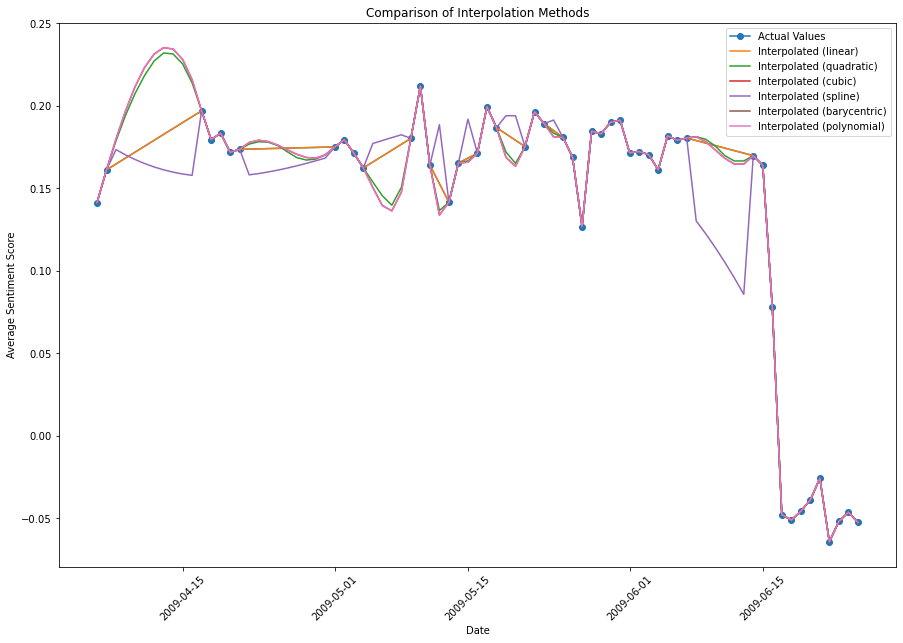

In [152]:
# Ensure 'date' is a datetime type and set as index
forecast_df['date'] = pd.to_datetime(forecast_df['date'])
forecast_df.set_index('date', inplace=True)

# Define different interpolation methods to try
interpolation_methods = {
    'linear': {},
    'quadratic': {},
    'cubic': {},
    'spline': {'order': 3},
    'barycentric': {},
    'polynomial': {'order': 3}
}

# Plot the actual values
plt.figure(figsize=(15, 10))
plt.plot(forecast_df.index, forecast_df['average_sentiment_score'], label='Actual Values', marker='o')

# Try each method and plot the interpolated series
for method, params in interpolation_methods.items():
    try:
        interpolated = forecast_df.asfreq('D').interpolate(method=method, **params)
        plt.plot(interpolated.index, interpolated['average_sentiment_score'], label=f'Interpolated ({method})')
    except ValueError as e:
        print(f"An error occurred with method '{method}': {e}")

# Additional plot settings
plt.legend()
plt.title('Comparison of Interpolation Methods')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()



## Step 6 : Time-series Forecasting for 1 week, 1 month and 3 Months Using Holt-Winters, ARIMA, SARIMA, VARMAX models

### 6.1 Holt-Winters Model with trend & Seasonal added with different Interpolation methods for Forecasting 

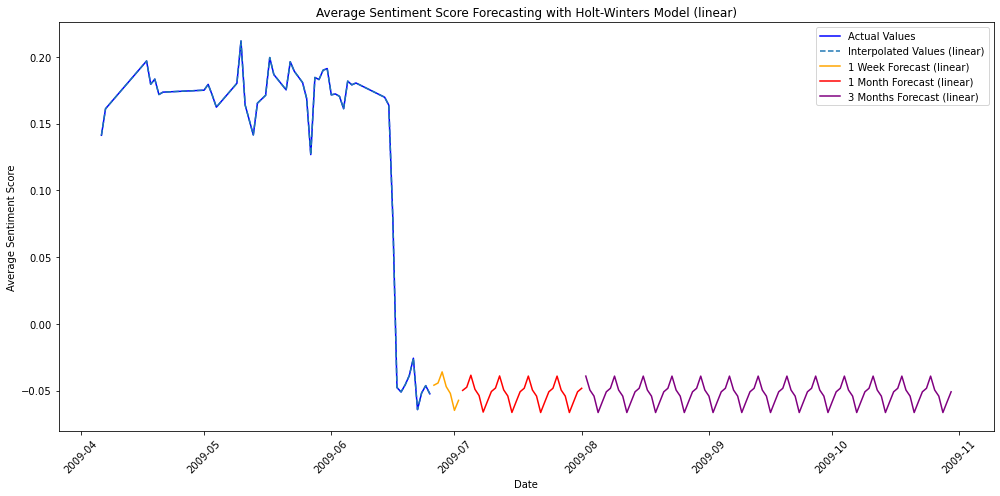

 linear, 3 Months Forecast - MAE: 0.20210328294063049, RMSE: 0.21395996722250946


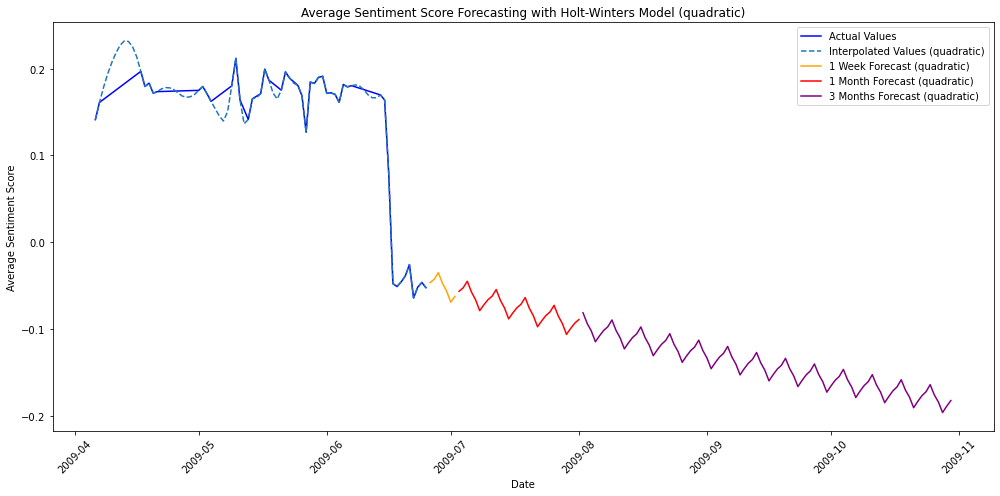

 quadratic, 3 Months Forecast - MAE: 0.24902611379689407, RMSE: 0.2571094654831384


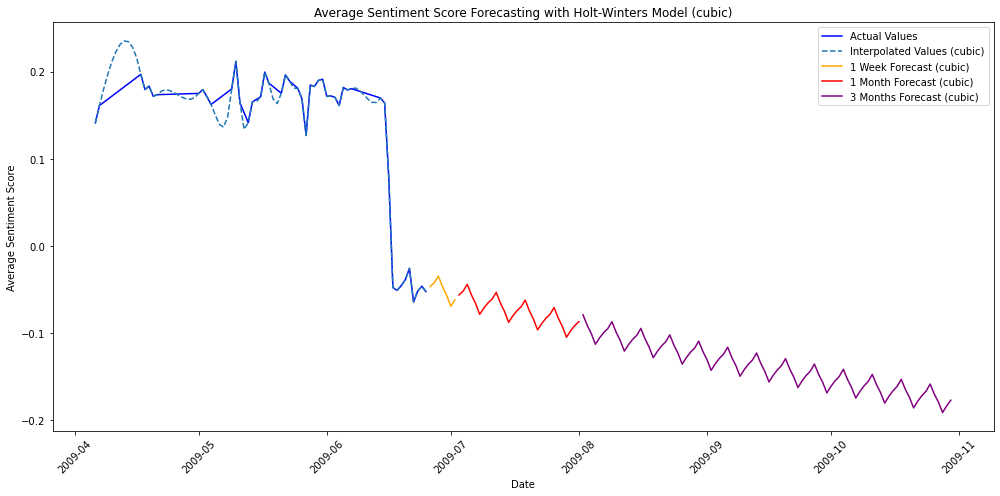

 cubic, 3 Months Forecast - MAE: 0.24691563154056181, RMSE: 0.2551807686404816


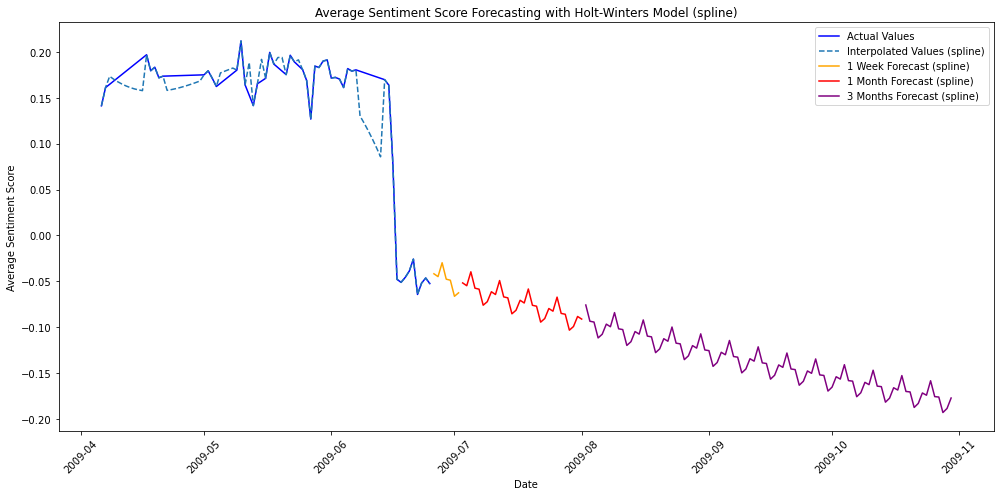

 spline, 3 Months Forecast - MAE: 0.23804579436020917, RMSE: 0.24620888190465437
Skipping barycentric due to NaN values after interpolation.


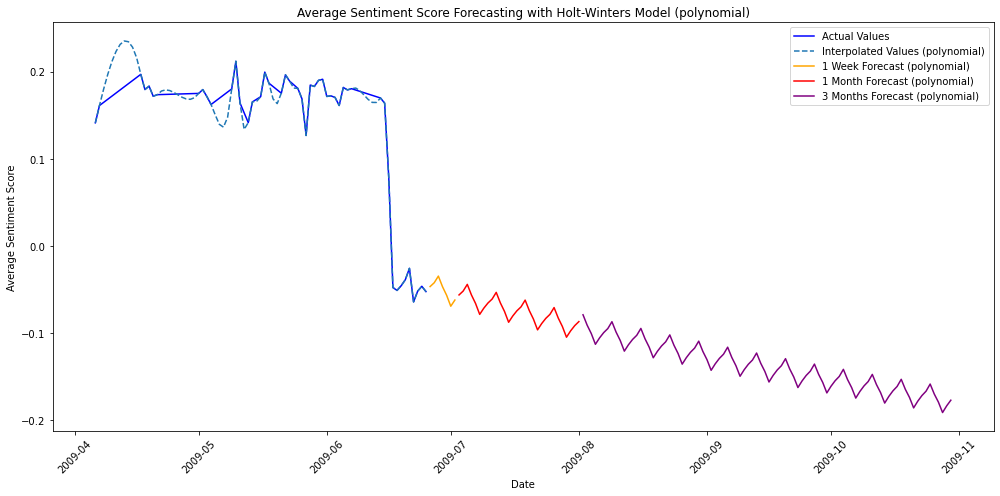

 polynomial, 3 Months Forecast - MAE: 0.24691563154056181, RMSE: 0.2551807686404816


In [191]:
# Define different interpolation methods to try
interpolation_methods = {
    'linear': {},
    'quadratic': {},
    'cubic': {},
    'spline': {'order': 3},
    'barycentric': {},
    'polynomial': {'order': 3}
}

# Iterate over each interpolation method

for method_name, method_params in interpolation_methods.items():
    # Create a copy of the dataframe for manipulation
    interpolated_df = forecast_df.asfreq('D').interpolate(method=method_name, **method_params)

    # Check if the dataframe is empty
    if interpolated_df.empty or interpolated_df['average_sentiment_score'].isna().any():
        print(f"Skipping {method_name} due to NaN values after interpolation.")
        continue

    # Apply Holt-Winters model with weekly seasonality
    model = ExponentialSmoothing(
        interpolated_df['average_sentiment_score'],
        trend='add',
        seasonal='add',
        seasonal_periods=7,
        damped_trend=True
    )
    results = model.fit()

  
    # Define the number of steps for 1 week, 1 month, and 3 months
    forecast_steps_week = 7
    forecast_steps_month = 30
    forecast_steps_3month = 90

    # Generate forecast for each time period
    forecast_week = results.forecast(steps=forecast_steps_week)
    forecast_month = results.forecast(steps=forecast_steps_month + forecast_steps_week)
    forecast_3month = results.forecast(steps=forecast_steps_3month + forecast_steps_month + forecast_steps_week)

    # Generate index for the forecasts starting from the last date in interpolated data
    last_date = interpolated_df.index[-1]
    forecast_index_week = pd.date_range(start=last_date, periods=forecast_steps_week + 1, closed='right')
    forecast_index_month = pd.date_range(start=last_date + pd.Timedelta(days=forecast_steps_week), periods=forecast_steps_month + 1, closed='right')
    forecast_index_3month = pd.date_range(start=last_date + pd.Timedelta(days=forecast_steps_week + forecast_steps_month), periods=forecast_steps_3month + 1, closed='right')
    
    observed_values_3month = interpolated_df['average_sentiment_score']  # Replace with your actual test data for 3 months

    # Align the forecasted values with the observed values
    # Make sure the indices match with the observed data
    forecast_3month_aligned = forecast_3month[:len(observed_values_3month)]

    # Calculate MAE and RMSE for each forecast period
    mae_3month = mean_absolute_error(observed_values_3month, forecast_3month_aligned)
    rmse_3month = np.sqrt(mean_squared_error(observed_values_3month, forecast_3month_aligned))
    
    # Plotting
    plt.figure(figsize=(14, 7))

    # Plot actual values
    plt.plot(forecast_df.index, forecast_df['average_sentiment_score'], label='Actual Values', color='blue')

    # Plot interpolated values
    plt.plot(interpolated_df.index, interpolated_df['average_sentiment_score'], label=f'Interpolated Values ({method_name})', linestyle='--')

    # Plot forecasted values for each period
    plt.plot(forecast_index_week, forecast_week, label=f'1 Week Forecast ({method_name})', color='orange')
    plt.plot(forecast_index_month, forecast_month[forecast_steps_week:], label=f'1 Month Forecast ({method_name})', color='red')
    plt.plot(forecast_index_3month, forecast_3month[forecast_steps_week + forecast_steps_month:], label=f'3 Months Forecast ({method_name})', color='purple')

    # Additional plot settings
    plt.legend()
    plt.title(f'Average Sentiment Score Forecasting with Holt-Winters Model ({method_name})')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
    plt.show()
    
        # Print the MAE and RMSE
    print(f" {method_name}, 3 Months Forecast - MAE: {mae_3month}, RMSE: {rmse_3month}")


### 6.2 SARIMAX model with Hyper parameter tuning for p,d,q triplets with weekly seasonality

Best SARIMAX model: ARIMA(1, 0, 1) x (0, 0, 0, 7) with AIC -374.88763232218145


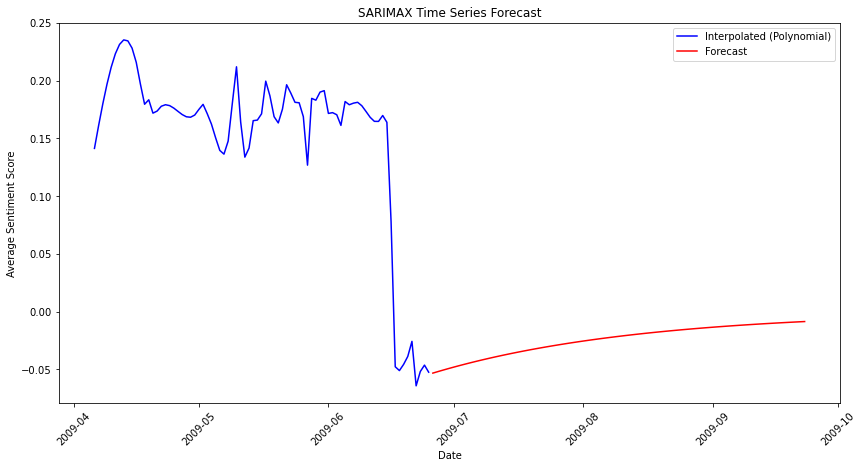

In [165]:
# Interpolate using polynomial method
interpolated_df = forecast_df.asfreq('D').interpolate(method='polynomial', order=3)

# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of seasonal p, d, q triplets
pdq = list(itertools.product(p, d, q))

# Seasonal order: Assuming potential weekly seasonality, we use 7 periods
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Grid search for the optimal SARIMAX parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(interpolated_df['average_sentiment_score'],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            # Compare this model's AIC to the best so far
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

print(f"Best SARIMAX model: ARIMA{best_pdq} x {best_seasonal_pdq} with AIC {best_aic}")

# Forecast the future values using the best model
forecast_steps = 90  # for 3 months
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=interpolated_df.index[-1], periods=forecast_steps+1, closed='right')
forecast_values = forecast.predicted_mean

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(interpolated_df.index, interpolated_df['average_sentiment_score'], label='Interpolated (Polynomial)', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.legend()
plt.title('SARIMAX Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()




In [175]:
# Assuming you have the actual observed values for the forecast period in a separate DataFrame
observed_values = interpolated_df['average_sentiment_score']  # Replace test_df with your actual test data

# Ensure the forecast_values and observed_values have the same length
forecast_values_aligned = forecast_values[:len(observed_values)]

# Calculate MAE and RMSE using the observed and forecasted values
mae = mean_absolute_error(observed_values, forecast_values_aligned)
rmse = np.sqrt(mean_squared_error(observed_values, forecast_values_aligned))

# Print out the AIC, MAE, and RMSE
print(f"Best SARIMAX model: ARIMA{best_pdq} x {best_seasonal_pdq} with AIC {best_model.aic}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")



Best SARIMAX model: ARIMA(1, 0, 1) x (0, 0, 0, 7) with AIC -374.88763232218145
MAE: 0.1853945150723741
RMSE: 0.1950673170312133


### 6.3 ARIMA Model with best parameters received from SARIMAX p,q,d (1,0,1) and Polynomial interpolation used

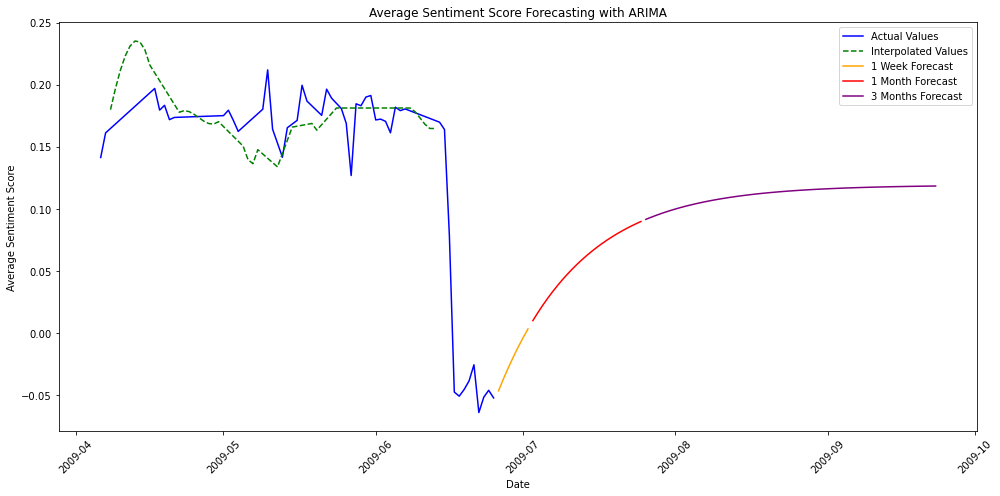

In [176]:

# Fill forward any NaN values (this assumes NaNs are where data is missing)
# interpolated_daily_sentiment = forecast_df.asfreq('D', method='pad')
interpolated_df = forecast_df.asfreq('D').interpolate(method='polynomial', order=3)

# Fit the ARIMA model on the interpolated data
# Replace (p, d, q) with your chosen order for the ARIMA model
p, d, q = 1, 0, 1
model = ARIMA(interpolated_df['average_sentiment_score'], order=(p, d, q))
results = model.fit()

# Define the number of steps for 1 week, 1 month, and 3 months
forecast_steps_week = 7
forecast_steps_month = 30
forecast_steps_3month = 90

# Generate forecast for each time period
forecast_week = results.get_forecast(steps=forecast_steps_week).predicted_mean
forecast_month = results.get_forecast(steps=forecast_steps_month).predicted_mean
forecast_3month = results.get_forecast(steps=forecast_steps_3month).predicted_mean

# Generate index for the forecasts starting from the last date in interpolated data
last_date = interpolated_df.index[-1]
forecast_index_week = pd.date_range(start=last_date, periods=forecast_steps_week + 1, closed='right')
forecast_index_month = pd.date_range(start=last_date, periods=forecast_steps_month + 1, closed='right')[forecast_steps_week:]
forecast_index_3month = pd.date_range(start=last_date, periods=forecast_steps_3month + 1, closed='right')[forecast_steps_month:]

# Plotting
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(forecast_df.index, forecast_df['average_sentiment_score'], label='Actual Values', color='blue')

# Identify and plot interpolated values only where actual values are missing
interpolated_dates = interpolated_df.index.difference(forecast_df.index)
plt.plot(interpolated_dates, interpolated_df['average_sentiment_score'][interpolated_dates], label='Interpolated Values', color='green', linestyle='--')

# Plot forecasted values
plt.plot(forecast_index_week, forecast_week, label='1 Week Forecast', color='orange')
plt.plot(forecast_index_month, forecast_month[forecast_steps_week:], label='1 Month Forecast', color='red')
plt.plot(forecast_index_3month, forecast_3month[forecast_steps_month:], label='3 Months Forecast', color='purple')

# Additional plot settings
plt.legend()
plt.title('Average Sentiment Score Forecasting with ARIMA')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


In [179]:

observed_values_3month = interpolated_df['average_sentiment_score']  # Replace with your actual test data for 3 months

# Align the forecasted values with the observed values
# Make sure the indices match with the observed data
forecast_3month_aligned = forecast_3month[:len(observed_values_3month)]

# Calculate MAE and RMSE for each forecast period
mae_3month = mean_absolute_error(observed_values_3month, forecast_3month_aligned)
rmse_3month = np.sqrt(mean_squared_error(observed_values_3month, forecast_3month_aligned))

# Print the MAE and RMSE
print(f"ARIMA 3 Months Forecast - MAE: {mae_3month}, RMSE: {rmse_3month}")


ARIMA 3 Months Forecast - MAE: 0.10460228729180285, RMSE: 0.11898135382156717



### 6.4 Using VARMAX forecasting technique using both variables Average_sentiment_score & total_tweets per day

Error with VARMAX(2, 1, 1): Schur decomposition solver error.
Error with VARMAX(2, 1, 2): Schur decomposition solver error.
Error with VARMAX(2, 2, 1): Schur decomposition solver error.
Error with VARMAX(2, 2, 2): Schur decomposition solver error.
Best VARMAX model: VARMAX(2, 1, 1) with AIC 144.29264921206683


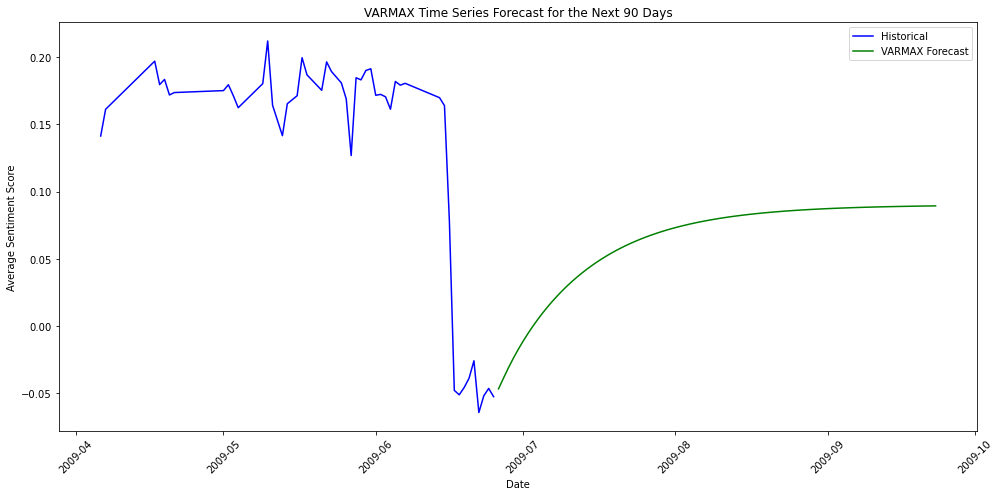

In [184]:
forecast_df[['average_sentiment_score', 'total_tweets']] = forecast_df[['average_sentiment_score', 'total_tweets']].asfreq('D').interpolate(method='polynomial', order=3)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(1, 3)

# Generate all different combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))

# VARMAX Hyperparameter tuning using Time Series Cross-Validation
best_aic_varmax = np.inf
best_pdq_varmax = None
best_model_varmax = None
best_fold = None

for train_index, test_index in tscv.split(forecast_df):
    train_df = forecast_df.iloc[train_index]
    test_df = forecast_df.iloc[test_index]
    
    for param in pdq:
        try:
            mod = VARMAX(train_df[['average_sentiment_score', 'total_tweets']], order=param)
            results = mod.fit()
            if results.aic < best_aic_varmax:
                best_aic_varmax = results.aic
                best_pdq_varmax = param
                best_model_varmax = results
                best_fold = (train_index, test_index)
        except Exception as e:
            print(f'Error with VARMAX{param}: {e}')

            
if best_model_varmax is not None:
    print(f"Best VARMAX model: VARMAX{best_pdq_varmax} with AIC {best_aic_varmax}")
    
    # Re-fit the VARMAX model on the entire dataset with the best parameters
    final_model = VARMAX(forecast_df[['average_sentiment_score', 'total_tweets']], order=best_pdq_varmax)
    final_results = final_model.fit()
    
    # Forecast the next 90 days
    forecast_steps = 90
    forecast_varmax = final_results.get_forecast(steps=forecast_steps)
    forecast_values_varmax = forecast_varmax.predicted_mean

    # Generate date index for the forecast
    last_date = forecast_df.index[-1]
    forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, closed='right')

    # Plot the results
    plt.figure(figsize=(14, 7))

    # Plot historical values
    plt.plot(forecast_df.index, forecast_df['average_sentiment_score'], label='Historical', color='blue')

    # Plot forecasted values
    plt.plot(forecast_index, forecast_values_varmax['average_sentiment_score'], label='VARMAX Forecast', color='green')

    plt.legend()
    plt.title('VARMAX Time Series Forecast for the Next 90 Days')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No suitable VARMAX model was found.")   


In [188]:
# Select the test dataset for the period you have forecasted
observed_values_var = interpolated_df['average_sentiment_score']

# Ensure the forecast_values and observed_values have the same length
forecast_values_var = forecast_values_varmax['average_sentiment_score'][:len(observed_values_var)]

# Calculate the forecast errors
mae_varmax = mean_absolute_error(observed_values_var, forecast_values_var)
mse_varmax = mean_squared_error(observed_values_var, forecast_values_var)
rmse_varmax = sqrt(mse_varmax)
print(f"Best VARMAX model: VARMAX{best_pdq_varmax} with AIC {best_aic_varmax}")
# Print the MAE and RMSE
print(f"VARMAX - MAE: {mae_varmax}, RMSE: {rmse_varmax}")


Best VARMAX model: VARMAX(2, 1, 1) with AIC 144.29264921206683
VARMAX - MAE: 0.12091997111980583, RMSE: 0.12988218138896934


## Step 7: Conclusions captured in report

### The End of Code